In [1]:
!pip install pandas==2.2.1

In [2]:
! pip install git+https://github.com/Nixtla/neuralforecast.git

  Cloning https://github.com/Nixtla/neuralforecast.git to /tmp/pip-req-build-gpmy9lg0
  Running command git clone --filter=blob:none --quiet https://github.com/Nixtla/neuralforecast.git /tmp/pip-req-build-gpmy9lg0
  Resolved https://github.com/Nixtla/neuralforecast.git to commit 6b0bca5dd81365a34f07c9c4c3ee53fd54abc3a7
  Running command git submodule update --init --recursive -q
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [5]:
from sqlalchemy import create_engine
import pandas as pd
import torch

database_url = "sqlite:////content/data.sqlite"
# database_url = "sqlite:///../data/data.sqlite"
engine = create_engine(database_url)

# define hyper paras
use_standard_scaler = True
save_imputed_data = False
notebook_mode = 'train'
device = torch.device("cuda:0" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")


In [6]:
query = "select date as ds,global_entry,hkmo_entry,tw_entry from sh_customs_daily_imputed"
data = pd.read_sql_query(query, engine)
original_data = data.copy()

In [7]:
# melting,转换为长格式
df_long = pd.melt(data, id_vars=['ds'], var_name='unique_id', value_name='y')
df_long['ds'] = pd.to_datetime(df_long.ds)

## 使用cross validation选择模型

使用colab V100 训练1小时

In [6]:
import os

# 防止gpu内存不足中断训练
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'

In [7]:
from neuralforecast.auto import AutoLSTM, AutoInformer, AutoAutoformer, AutoPatchTST, AutoiTransformer, AutoFEDformer
from ray import tune
from neuralforecast.core import NeuralForecast

horizon = 30
lstm_config = {
    "input_size": tune.choice([horizon * 4, horizon * 16, horizon * 32]),
    "h": None,
    "encoder_hidden_size": tune.choice([50, 100, 200]),
    "encoder_n_layers": tune.randint(1, 4),
    "context_size": tune.choice([5, 10, 50]),
    "decoder_hidden_size": tune.choice([64, 128, 256]),
    "learning_rate": tune.loguniform(1e-4, 1e-1),
    "max_steps": tune.choice([300, 500, 700]),
    "batch_size": tune.choice([16, 32]),
    "random_seed": tune.randint(1, 20),
}

informer_config = {
    "input_size": tune.choice([horizon, horizon * 2]),
    "h": None,
    "hidden_size": tune.choice([64, 128, 256]),
    "n_head": tune.choice([4, 8]),
    "learning_rate": tune.loguniform(1e-4, 1e-1),
    "scaler_type": tune.choice(["robust", "standard", "minmax"]),
    "max_steps": tune.choice([300, 500, 1000]),
    "batch_size": tune.choice([32, 64, 128]),
    "windows_batch_size": tune.choice([128, 256, 512]),
    "random_seed": tune.randint(1, 20),
}

autoformer_config = {
    "input_size": tune.choice([horizon, horizon * 2]),
    "h": None,
    "hidden_size": tune.choice([64, 128, 256]),
    "n_head": tune.choice([4, 8]),
    "learning_rate": tune.loguniform(1e-4, 1e-1),
    "scaler_type": tune.choice(["robust", "standard", "minmax"]),
    "max_steps": tune.choice([300, 500, 1000]),
    "batch_size": tune.choice([32, 64, 128]),
    "windows_batch_size": tune.choice([128, 256, 512]),
    "random_seed": tune.randint(1, 20),
}

pathtst_config = {
    "input_size": tune.choice([horizon, horizon * 2]),
    "h": None,
    "hidden_size": tune.choice([64, 128, 256]),
    "n_heads": tune.choice([4, 8]),
    "patch_len": tune.choice([16, 24]),
    "learning_rate": tune.loguniform(1e-4, 1e-1),
    "scaler_type": tune.choice(["robust", "standard", "minmax"]),
    "revin": True,
    "revin_affine": tune.choice([True, False]),
    "max_steps": tune.choice([500, 700, 1000]),
    "batch_size": tune.choice([32, 64, 128]),
    "windows_batch_size": tune.choice([128, 256, 512]),
    "random_seed": tune.randint(1, 20),
}

itransformer_config = {
    "input_size": tune.choice([horizon, horizon * 2]),
    "h": None,
    "n_series": None,
    "hidden_size": tune.choice([64, 128, 256]),
    "n_heads": tune.choice([4, 8]),
    "learning_rate": tune.loguniform(1e-4, 1e-1),
    "scaler_type": tune.choice(["robust", "standard", "minmax"]),
    "max_steps": tune.choice([500, 700, 1000]),
    "batch_size": tune.choice([32, 64, 128]),
    "loss": None,
    "random_seed": tune.randint(1, 20),
}

models = [
    # baseline
    AutoLSTM(
        h=horizon,  # input size has a multiplier, 1~5
        config=lstm_config,
        # loss= 'mae', # default is MAE
        verbose=True,  # track progress
        num_samples=5,  # try 5
        backend='ray'
    ),
    # transformer-based model1
    AutoInformer(
        h=horizon,  # input size has a multiplier, 1~5
        config=informer_config,
        # loss= 'mae', # default is MAE
        verbose=True,  # track progress
        num_samples=5,  # try 5
        backend='ray'
    ),
    # transformer-based model2
    AutoAutoformer(
        h=horizon,  # input size has a multiplier, 1~5
        config=autoformer_config,
        # loss= 'mae', # default is MAE
        verbose=True,  # track progress
        num_samples=5,  # try 5
        backend='ray'
    ),
    # transformer-based model3
    AutoPatchTST(
        h=horizon,  # input size has a multiplier, 1~5
        config=pathtst_config,
        # loss= 'mae', # default is MAE
        verbose=True,  # track progress
        num_samples=5,  # try 5
        backend='ray'
    ),
    # transformer-based model4
    AutoiTransformer(
        h=horizon,  # input size has a multiplier, 1~5
        n_series=3,
        config=itransformer_config,
        # loss= 'mae', # default is MAE
        verbose=True,  # track progress
        num_samples=5,  # try 5
        backend='ray'
    )
]

nf = NeuralForecast(
    models=models,
    freq='1D',
)
cross_val = nf.cross_validation(df_long, val_size=int(0.1 * len(df_long)), test_size=int(0.1 * len(df_long)),
                                n_windows=None)

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/utilities/parsing.py:199: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
2024-04-07 00:53:12,931	INFO worker.py:1752 -- Started a local Ray instance.
2024-04-07 00:53:14,588	INFO tune.py:263 -- Initializing Ray automatically. For cluster usage or custom Ray initialization, call `ray.init(...)` before `Tuner(...)`.
2024-04-07 00:53:14,595	INFO tune.py:622 -- [output] This will use the new output engine with verbosity 1. To disable the new output and use the legacy output engine, set the environment variable RAY_AIR_NEW_OUTPUT=0. For more information, please see https://github.com/ray-project/ray/issues/36949


+--------------------------------------------------------------------+
| Configuration for experiment     _train_tune_2024-04-07_00-53-10   |
+--------------------------------------------------------------------+
| Search algorithm                 BasicVariantGenerator             |
| Scheduler                        FIFOScheduler                     |
| Number of trials                 5                                 |
+--------------------------------------------------------------------+

View detailed results here: /root/ray_results/_train_tune_2024-04-07_00-53-10
To visualize your results with TensorBoard, run: `tensorboard --logdir /tmp/ray/session_2024-04-07_00-53-10_455366_3797/artifacts/2024-04-07_00-53-14/_train_tune_2024-04-07_00-53-10/driver_artifacts`

Trial status: 5 PENDING
Current time: 2024-04-07 00:53:15. Total running time: 0s
Logical resource usage: 0/2 CPUs, 0/1 GPUs (0.0/1.0 accelerator_type:V100)
+-----------------------------------------------------------------

(_train_tune pid=4552) /usr/local/lib/python3.10/dist-packages/ray/tune/integration/pytorch_lightning.py:194: `ray.tune.integration.pytorch_lightning.TuneReportCallback` is deprecated. Use `ray.tune.integration.pytorch_lightning.TuneReportCheckpointCallback` instead.
(_train_tune pid=4552) /usr/local/lib/python3.10/dist-packages/pytorch_lightning/utilities/parsing.py:199: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
(_train_tune pid=4552) /usr/local/lib/python3.10/dist-packages/pytorch_lightning/utilities/parsing.py:199: Attribute 'valid_loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['valid_loss'])`.
(_train_tune pid=4552) Seed set to 1
(_train_tune pid=4552) GPU available: True (cuda), used: True
(_train_tune pid=4552) TPU available: False, using: 0 TPU

Sanity Checking: |          | 0/? [00:00<?, ?it/s]
Epoch 0:   0%|          | 0/1 [00:00<?, ?it/s] 


(_train_tune pid=4552) /usr/local/lib/python3.10/dist-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 77.50it/s, v_num=0, train_loss_step=1.010, train_loss_epoch=0.983]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(_train_tune pid=4552) 
Epoch 199: 100%|██████████| 1/1 [00:00<00:00, 65.83it/s, v_num=0, train_loss_step=0.950, train_loss_epoch=0.882, valid_loss=1.15e+3]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 299: 100%|██████████| 1/1 [00:00<00:00, 59.81it/s, v_num=0, train_loss_step=0.846, train_loss_epoch=0.799, valid_loss=1.11e+3]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 399: 100%|██████████| 1/1 [00:00<00:00, 77.25it/s, v_num=0, train_loss_step=0.690, train_loss_epoch=0.703, valid_loss=1.01e+3]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 499: 100%|██████████| 1/1 [00:00<00:00, 77.18it/s, v_num=0, train_loss_step=0.509, train_loss_epoch=0.538, valid_loss=935.0]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 599: 100%|██████████| 1/1 [00:00<00

(_train_tune pid=4552) `Trainer.fit` stopped: `max_steps=700` reached.



Trial status: 1 TERMINATED | 4 PENDING
Current time: 2024-04-07 00:53:45. Total running time: 30s
Logical resource usage: 0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:V100)
Current best trial: 3446f_00000 with loss=689.6708374023438 and params={'input_size': 960, 'h': 30, 'encoder_hidden_size': 100, 'encoder_n_layers': 1, 'context_size': 50, 'decoder_hidden_size': 64, 'learning_rate': 0.06435730042061336, 'max_steps': 700, 'batch_size': 32, 'random_seed': 1, 'loss': MAE(), 'valid_loss': MAE()}
+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status         input_size     encoder_hidden_size     encoder_n_layers     context_size     decoder_hidden_size     learning_rate     max_steps     batch_size     random_seed     iter     total time (s)      loss

(_train_tune pid=4718) /usr/local/lib/python3.10/dist-packages/ray/tune/integration/pytorch_lightning.py:194: `ray.tune.integration.pytorch_lightning.TuneReportCallback` is deprecated. Use `ray.tune.integration.pytorch_lightning.TuneReportCheckpointCallback` instead.
(_train_tune pid=4718) /usr/local/lib/python3.10/dist-packages/pytorch_lightning/utilities/parsing.py:199: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
(_train_tune pid=4718) /usr/local/lib/python3.10/dist-packages/pytorch_lightning/utilities/parsing.py:199: Attribute 'valid_loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['valid_loss'])`.
(_train_tune pid=4718) Seed set to 6
(_train_tune pid=4718) GPU available: True (cuda), used: True
(_train_tune pid=4718) TPU available: False, using: 0 TPU

Epoch 0:   0%|          | 0/1 [00:00<?, ?it/s] 


(_train_tune pid=4718) /usr/local/lib/python3.10/dist-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 26.72it/s, v_num=0, train_loss_step=0.912, train_loss_epoch=0.976]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(_train_tune pid=4718) 
Epoch 199: 100%|██████████| 1/1 [00:00<00:00, 26.85it/s, v_num=0, train_loss_step=0.733, train_loss_epoch=0.794, valid_loss=1.14e+3]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(_train_tune pid=4718) 
Epoch 299: 100%|██████████| 1/1 [00:00<00:00, 21.89it/s, v_num=0, train_loss_step=0.427, train_loss_epoch=0.436, valid_loss=926.0]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]

Trial _train_tune_3446f_00001 completed after 3 iterations at 2024-04-07 00:54:08. Total running time: 53s
+--------------------------------------------------+
| Trial _train_tune_3446f_00001 result             |
+----------------------------------

(_train_tune pid=4718) `Trainer.fit` stopped: `max_steps=300` reached.



Trial status: 2 TERMINATED | 3 PENDING
Current time: 2024-04-07 00:54:15. Total running time: 1min 0s
Logical resource usage: 0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:V100)
Current best trial: 3446f_00001 with loss=660.738525390625 and params={'input_size': 480, 'h': 30, 'encoder_hidden_size': 200, 'encoder_n_layers': 3, 'context_size': 10, 'decoder_hidden_size': 64, 'learning_rate': 0.0015609620802978473, 'max_steps': 300, 'batch_size': 32, 'random_seed': 6, 'loss': MAE(), 'valid_loss': MAE()}
+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status         input_size     encoder_hidden_size     encoder_n_layers     context_size     decoder_hidden_size     learning_rate     max_steps     batch_size     random_seed     iter     total time (s)     

(_train_tune pid=4871) /usr/local/lib/python3.10/dist-packages/ray/tune/integration/pytorch_lightning.py:194: `ray.tune.integration.pytorch_lightning.TuneReportCallback` is deprecated. Use `ray.tune.integration.pytorch_lightning.TuneReportCheckpointCallback` instead.
(_train_tune pid=4871) /usr/local/lib/python3.10/dist-packages/pytorch_lightning/utilities/parsing.py:199: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
(_train_tune pid=4871) /usr/local/lib/python3.10/dist-packages/pytorch_lightning/utilities/parsing.py:199: Attribute 'valid_loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['valid_loss'])`.
(_train_tune pid=4871) Seed set to 10
(_train_tune pid=4871) GPU available: True (cuda), used: True
(_train_tune pid=4871) TPU available: False, using: 0 TP

Sanity Checking DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
                                                                           
Epoch 0:   0%|          | 0/1 [00:00<?, ?it/s] 


(_train_tune pid=4871) /usr/local/lib/python3.10/dist-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 53.46it/s, v_num=0, train_loss_step=0.808, train_loss_epoch=0.812]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 38.28it/s]
(_train_tune pid=4871) 
Epoch 199: 100%|██████████| 1/1 [00:00<00:00, 32.99it/s, v_num=0, train_loss_step=0.371, train_loss_epoch=0.351, valid_loss=955.0]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 299: 100%|██████████| 1/1 [00:00<00:00, 51.86it/s, v_num=0, train_loss_step=0.273, train_loss_epoch=0.265, valid_loss=671.0]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 399: 100%|██████████| 1/1 [00:00<00:00, 46.61it/s, v_num=0, train_loss_step=0.212, train_loss_epoch=0.202, valid_loss=580.0]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 499: 100%|██████████| 1/1 [00:00<00:00, 50.74it/s, v_num=0, train_loss_step=0.200, train_loss_epoch=0.218, valid_loss=530.0]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|         

(_train_tune pid=4871) `Trainer.fit` stopped: `max_steps=500` reached.



Trial _train_tune_3446f_00003 started with configuration:
+--------------------------------------------------+
| Trial _train_tune_3446f_00003 config             |
+--------------------------------------------------+
| batch_size                                    16 |
| context_size                                  10 |
| decoder_hidden_size                          256 |
| encoder_hidden_size                           50 |
| encoder_n_layers                               1 |
| h                                             30 |
| input_size                                   480 |
| learning_rate                            0.00043 |
| loss                                       MAE() |
| max_steps                                    500 |
| random_seed                                    5 |
| valid_loss                                 MAE() |
+--------------------------------------------------+


(_train_tune pid=5020) /usr/local/lib/python3.10/dist-packages/ray/tune/integration/pytorch_lightning.py:194: `ray.tune.integration.pytorch_lightning.TuneReportCallback` is deprecated. Use `ray.tune.integration.pytorch_lightning.TuneReportCheckpointCallback` instead.
(_train_tune pid=5020) /usr/local/lib/python3.10/dist-packages/pytorch_lightning/utilities/parsing.py:199: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
(_train_tune pid=5020) /usr/local/lib/python3.10/dist-packages/pytorch_lightning/utilities/parsing.py:199: Attribute 'valid_loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['valid_loss'])`.
(_train_tune pid=5020) Seed set to 5
(_train_tune pid=5020) GPU available: True (cuda), used: True
(_train_tune pid=5020) TPU available: False, using: 0 TPU


Trial status: 3 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2024-04-07 00:54:45. Total running time: 1min 30s
Logical resource usage: 0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:V100)
Current best trial: 3446f_00002 with loss=571.1472778320312 and params={'input_size': 960, 'h': 30, 'encoder_hidden_size': 100, 'encoder_n_layers': 2, 'context_size': 5, 'decoder_hidden_size': 256, 'learning_rate': 0.009934604574565497, 'max_steps': 500, 'batch_size': 32, 'random_seed': 10, 'loss': MAE(), 'valid_loss': MAE()}
+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status         input_size     encoder_hidden_size     encoder_n_layers     context_size     decoder_hidden_size     learning_rate     max_steps     batch_size     random_seed     iter     total

(_train_tune pid=5020) /usr/local/lib/python3.10/dist-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 95.39it/s, v_num=0, train_loss_step=1.080, train_loss_epoch=0.950]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 199: 100%|██████████| 1/1 [00:00<00:00, 109.95it/s, v_num=0, train_loss_step=0.989, train_loss_epoch=1.040, valid_loss=1.21e+3]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 299: 100%|██████████| 1/1 [00:00<00:00, 107.93it/s, v_num=0, train_loss_step=0.973, train_loss_epoch=1.000, valid_loss=1.16e+3]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 399: 100%|██████████| 1/1 [00:00<00:00, 111.42it/s, v_num=0, train_loss_step=1.010, train_loss_epoch=0.981, valid_loss=1.16e+3]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 499: 100%|██████████| 1/1 [00:00<00:00, 114.93it/s, v_num=0, train_loss_step=1.020, train_loss_epoch=1.020, valid_loss=1.12e+3]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 499: 100%|██████████| 1/1 [00:00<00:00, 26.01it/s, v_num=0, train_loss_step=1.020, train_loss_epoch=1.020, valid_los

(_train_tune pid=5020) `Trainer.fit` stopped: `max_steps=500` reached.



Trial _train_tune_3446f_00004 started with configuration:
+--------------------------------------------------+
| Trial _train_tune_3446f_00004 config             |
+--------------------------------------------------+
| batch_size                                    16 |
| context_size                                   5 |
| decoder_hidden_size                           64 |
| encoder_hidden_size                          200 |
| encoder_n_layers                               1 |
| h                                             30 |
| input_size                                   960 |
| learning_rate                            0.01964 |
| loss                                       MAE() |
| max_steps                                    700 |
| random_seed                                   12 |
| valid_loss                                 MAE() |
+--------------------------------------------------+


(_train_tune pid=5132) /usr/local/lib/python3.10/dist-packages/ray/tune/integration/pytorch_lightning.py:194: `ray.tune.integration.pytorch_lightning.TuneReportCallback` is deprecated. Use `ray.tune.integration.pytorch_lightning.TuneReportCheckpointCallback` instead.
(_train_tune pid=5132) /usr/local/lib/python3.10/dist-packages/pytorch_lightning/utilities/parsing.py:199: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
(_train_tune pid=5132) /usr/local/lib/python3.10/dist-packages/pytorch_lightning/utilities/parsing.py:199: Attribute 'valid_loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['valid_loss'])`.
(_train_tune pid=5132) Seed set to 12
(_train_tune pid=5132) GPU available: True (cuda), used: True
(_train_tune pid=5132) TPU available: False, using: 0 TP

Sanity Checking DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(_train_tune pid=5132) /usr/local/lib/python3.10/dist-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 19.65it/s, v_num=0, train_loss_step=0.905, train_loss_epoch=0.922]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 17.29it/s]
(_train_tune pid=5132) 
Epoch 199: 100%|██████████| 1/1 [00:00<00:00, 26.65it/s, v_num=0, train_loss_step=0.538, train_loss_epoch=0.508, valid_loss=1.03e+3]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 293:   0%|          | 0/1 [00:00<?, ?it/s, v_num=0, train_loss_step=0.314, train_loss_epoch=0.314, valid_loss=800.0]

Trial status: 4 TERMINATED | 1 RUNNING
Current time: 2024-04-07 00:55:15. Total running time: 2min 0s
Logical resource usage: 0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:V100)
Current best trial: 3446f_00002 with loss=571.1472778320312 and params={'input_size': 960, 'h': 30, 'encoder_hidden_size': 100, 'encoder_n_layers': 2, 'context_size': 5, 'decoder_hidden_size': 256, 'learning_rate': 0.009934604574565497, 'max_steps': 500, 'batch_siz

2024-04-07 00:55:31,626	INFO tune.py:1016 -- Wrote the latest version of all result files and experiment state to '/root/ray_results/_train_tune_2024-04-07_00-53-10' in 0.0085s.
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/utilities/parsing.py:199: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/utilities/parsing.py:199: Attribute 'valid_loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['valid_loss'])`.
INFO:lightning_fabric.utilities.seed:Seed set to 12


Epoch 699: 100%|██████████| 1/1 [00:00<00:00, 29.51it/s, v_num=0, train_loss_step=0.159, train_loss_epoch=0.131, valid_loss=498.0]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]

Trial _train_tune_3446f_00004 completed after 7 iterations at 2024-04-07 00:55:31. Total running time: 2min 16s
+--------------------------------------------------+
| Trial _train_tune_3446f_00004 result             |
+--------------------------------------------------+
| checkpoint_dir_name                              |
| time_this_iter_s                         3.73586 |
| time_total_s                             32.3366 |
| training_iteration                             7 |
| loss                                     456.865 |
| train_loss                               0.15881 |
+--------------------------------------------------+

Trial status: 5 TERMINATED
Current time: 2024-04-07 00:55:31. Total running time: 2min 16s
Logical resource usage: 0

(_train_tune pid=5132) `Trainer.fit` stopped: `max_steps=700` reached.


(_train_tune pid=5132) 
Epoch 699: 100%|██████████| 1/1 [00:00<00:00, 11.81it/s, v_num=0, train_loss_step=0.159, train_loss_epoch=0.159, valid_loss=457.0]


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name            | Type          | Params
--------------------------------------------------
0 | padder          | ConstantPad1d | 0     
1 | loss            | MAE           | 0     
2 | scaler          | TemporalNorm  | 0     
3 | hist_encoder    | LSTM          | 162 K 
4 | context_adapter | Linear        | 30.2 K
5 | mlp_decoder     | MLP           | 449   
--------------------------------------------------
192 K     Trainable params
0         Non-trainable params
192 K     Total params
0.772     Total estimated model params size (MB

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=700` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

2024-04-07 00:56:40,461	INFO tune.py:622 -- [output] This will use the new output engine with verbosity 1. To disable the new output and use the legacy output engine, set the environment variable RAY_AIR_NEW_OUTPUT=0. For more information, please see https://github.com/ray-project/ray/issues/36949


+--------------------------------------------------------------------+
| Configuration for experiment     _train_tune_2024-04-07_00-56-40   |
+--------------------------------------------------------------------+
| Search algorithm                 BasicVariantGenerator             |
| Scheduler                        FIFOScheduler                     |
| Number of trials                 5                                 |
+--------------------------------------------------------------------+

View detailed results here: /root/ray_results/_train_tune_2024-04-07_00-56-40
To visualize your results with TensorBoard, run: `tensorboard --logdir /tmp/ray/session_2024-04-07_00-53-10_455366_3797/artifacts/2024-04-07_00-56-40/_train_tune_2024-04-07_00-56-40/driver_artifacts`

Trial status: 5 PENDING
Current time: 2024-04-07 00:56:40. Total running time: 0s
Logical resource usage: 0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:V100)
+---------------------------------------------------------------

(_train_tune pid=5627) /usr/local/lib/python3.10/dist-packages/ray/tune/integration/pytorch_lightning.py:194: `ray.tune.integration.pytorch_lightning.TuneReportCallback` is deprecated. Use `ray.tune.integration.pytorch_lightning.TuneReportCheckpointCallback` instead.
(_train_tune pid=5627) /usr/local/lib/python3.10/dist-packages/pytorch_lightning/utilities/parsing.py:199: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
(_train_tune pid=5627) /usr/local/lib/python3.10/dist-packages/pytorch_lightning/utilities/parsing.py:199: Attribute 'valid_loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['valid_loss'])`.
(_train_tune pid=5627) Seed set to 8
(_train_tune pid=5627) GPU available: True (cuda), used: True
(_train_tune pid=5627) TPU available: False, using: 0 TPU

Sanity Checking: |          | 0/? [00:00<?, ?it/s]
Sanity Checking DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(_train_tune pid=5627) /usr/local/lib/python3.10/dist-packages/pytorch_lightning/utilities/data.py:77: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 3. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
(_train_tune pid=5627) /usr/local/lib/python3.10/dist-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 25.45it/s, v_num=0, train_loss_step=0.800, train_loss_epoch=0.768]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(_train_tune pid=5627) 
Epoch 199: 100%|██████████| 1/1 [00:00<00:00, 23.16it/s, v_num=0, train_loss_step=0.676, train_loss_epoch=0.632, valid_loss=829.0]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(_train_tune pid=5627) 
Epoch 299: 100%|██████████| 1/1 [00:00<00:00, 19.46it/s, v_num=0, train_loss_step=0.583, train_loss_epoch=0.564, valid_loss=730.0]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(_train_tune pid=5627) 
Epoch 371:   0%|          | 0/1 [00:00<?, ?it/s, v_num=0, train_loss_step=0.554, train_loss_epoch=0.554, valid_loss=661.0]

Trial status: 1 RUNNING | 4 PENDING
Current time: 2024-04-07 00:57:10. Total running time: 30s
Logical 

(_train_tune pid=5627) `Trainer.fit` stopped: `max_steps=500` reached.



Trial _train_tune_34478_00001 started with configuration:
+---------------------------------------------------+
| Trial _train_tune_34478_00001 config              |
+---------------------------------------------------+
| batch_size                                     64 |
| h                                              30 |
| hidden_size                                   128 |
| input_size                                     60 |
| learning_rate                             0.00086 |
| loss                                        MAE() |
| max_steps                                     500 |
| n_head                                          4 |
| random_seed                                     5 |
| scaler_type                              standard |
| valid_loss                                  MAE() |
| windows_batch_size                            512 |
+---------------------------------------------------+


(_train_tune pid=5814) /usr/local/lib/python3.10/dist-packages/ray/tune/integration/pytorch_lightning.py:194: `ray.tune.integration.pytorch_lightning.TuneReportCallback` is deprecated. Use `ray.tune.integration.pytorch_lightning.TuneReportCheckpointCallback` instead.
(_train_tune pid=5814) /usr/local/lib/python3.10/dist-packages/pytorch_lightning/utilities/parsing.py:199: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
(_train_tune pid=5814) /usr/local/lib/python3.10/dist-packages/pytorch_lightning/utilities/parsing.py:199: Attribute 'valid_loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['valid_loss'])`.
(_train_tune pid=5814) Seed set to 5
(_train_tune pid=5814) GPU available: True (cuda), used: True
(_train_tune pid=5814) TPU available: False, using: 0 TPU

Epoch 0:   0%|          | 0/1 [00:00<?, ?it/s] 


(_train_tune pid=5814) /usr/local/lib/python3.10/dist-packages/pytorch_lightning/utilities/data.py:77: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 3. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
(_train_tune pid=5814) /usr/local/lib/python3.10/dist-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 22.75it/s, v_num=0, train_loss_step=0.780, train_loss_epoch=0.772]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(_train_tune pid=5814) 
Epoch 197:   0%|          | 0/1 [00:00<?, ?it/s, v_num=0, train_loss_step=0.685, train_loss_epoch=0.685, valid_loss=904.0]

Trial status: 1 TERMINATED | 1 RUNNING | 3 PENDING
Current time: 2024-04-07 00:57:40. Total running time: 1min 0s
Logical resource usage: 0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:V100)
Current best trial: 34478_00000 with loss=573.540771484375 and params={'input_size': 30, 'h': 30, 'hidden_size': 64, 'n_head': 8, 'learning_rate': 0.006988572902708858, 'scaler_type': 'standard', 'max_steps': 500, 'batch_size': 64, 'windows_batch_size': 512, 'random_seed': 8, 'loss': MAE(), 'valid_loss': MAE()}
+------------------------------------------------------------------------------------------------------------------------------

(_train_tune pid=5814) `Trainer.fit` stopped: `max_steps=500` reached.



Trial _train_tune_34478_00002 started with configuration:
+---------------------------------------------------+
| Trial _train_tune_34478_00002 config              |
+---------------------------------------------------+
| batch_size                                     64 |
| h                                              30 |
| hidden_size                                   128 |
| input_size                                     60 |
| learning_rate                              0.0038 |
| loss                                        MAE() |
| max_steps                                     500 |
| n_head                                          4 |
| random_seed                                    18 |
| scaler_type                              standard |
| valid_loss                                  MAE() |
| windows_batch_size                            256 |
+---------------------------------------------------+


(_train_tune pid=6022) /usr/local/lib/python3.10/dist-packages/ray/tune/integration/pytorch_lightning.py:194: `ray.tune.integration.pytorch_lightning.TuneReportCallback` is deprecated. Use `ray.tune.integration.pytorch_lightning.TuneReportCheckpointCallback` instead.
(_train_tune pid=6022) /usr/local/lib/python3.10/dist-packages/pytorch_lightning/utilities/parsing.py:199: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
(_train_tune pid=6022) /usr/local/lib/python3.10/dist-packages/pytorch_lightning/utilities/parsing.py:199: Attribute 'valid_loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['valid_loss'])`.
(_train_tune pid=6022) Seed set to 18
(_train_tune pid=6022) GPU available: True (cuda), used: True
(_train_tune pid=6022) TPU available: False, using: 0 TP

Epoch 0:   0%|          | 0/1 [00:00<?, ?it/s] 


(_train_tune pid=6022) /usr/local/lib/python3.10/dist-packages/pytorch_lightning/utilities/data.py:77: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 3. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
(_train_tune pid=6022) /usr/local/lib/python3.10/dist-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 23:   0%|          | 0/1 [00:00<?, ?it/s, v_num=0, train_loss_step=0.954, train_loss_epoch=0.954]

Trial status: 2 TERMINATED | 1 RUNNING | 2 PENDING
Current time: 2024-04-07 00:58:10. Total running time: 1min 30s
Logical resource usage: 0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:V100)
Current best trial: 34478_00000 with loss=573.540771484375 and params={'input_size': 30, 'h': 30, 'hidden_size': 64, 'n_head': 8, 'learning_rate': 0.006988572902708858, 'scaler_type': 'standard', 'max_steps': 500, 'batch_size': 64, 'windows_batch_size': 512, 'random_seed': 8, 'loss': MAE(), 'valid_loss': MAE()}
+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status         input_size     hidden_size     n_head     learning_rate   scaler_type       max_steps     batch_size     wind

(_train_tune pid=6022) `Trainer.fit` stopped: `max_steps=500` reached.



Trial _train_tune_34478_00003 started with configuration:
+---------------------------------------------------+
| Trial _train_tune_34478_00003 config              |
+---------------------------------------------------+
| batch_size                                     64 |
| h                                              30 |
| hidden_size                                    64 |
| input_size                                     60 |
| learning_rate                             0.05688 |
| loss                                        MAE() |
| max_steps                                     300 |
| n_head                                          4 |
| random_seed                                    18 |
| scaler_type                              standard |
| valid_loss                                  MAE() |
| windows_batch_size                            512 |
+---------------------------------------------------+


(_train_tune pid=6210) /usr/local/lib/python3.10/dist-packages/ray/tune/integration/pytorch_lightning.py:194: `ray.tune.integration.pytorch_lightning.TuneReportCallback` is deprecated. Use `ray.tune.integration.pytorch_lightning.TuneReportCheckpointCallback` instead.
(_train_tune pid=6210) /usr/local/lib/python3.10/dist-packages/pytorch_lightning/utilities/parsing.py:199: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
(_train_tune pid=6210) /usr/local/lib/python3.10/dist-packages/pytorch_lightning/utilities/parsing.py:199: Attribute 'valid_loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['valid_loss'])`.
(_train_tune pid=6210) Seed set to 18
(_train_tune pid=6210) GPU available: True (cuda), used: True
(_train_tune pid=6210) TPU available: False, using: 0 TP


Trial status: 3 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2024-04-07 00:58:40. Total running time: 2min 0s
Logical resource usage: 0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:V100)
Current best trial: 34478_00000 with loss=573.540771484375 and params={'input_size': 30, 'h': 30, 'hidden_size': 64, 'n_head': 8, 'learning_rate': 0.006988572902708858, 'scaler_type': 'standard', 'max_steps': 500, 'batch_size': 64, 'windows_batch_size': 512, 'random_seed': 8, 'loss': MAE(), 'valid_loss': MAE()}
+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status         input_size     hidden_size     n_head     learning_rate   scaler_type       max_steps     batch_size     windows_batch_size     random_seed     iter     total time (s)      loss     train_loss |
+------------------

(_train_tune pid=6210) 2024-04-07 00:58:42.755250: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(_train_tune pid=6210) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
(_train_tune pid=6210) 
(_train_tune pid=6210)   | Name          | Type          | Params
(_train_tune pid=6210) ------------------------------------------------
(_train_tune pid=6210) 0 | padder_train  | ConstantPad1d | 0     
(_train_tune pid=6210) 1 | loss          | MAE           | 0     
(_train_tune pid=6210) 2 | scaler        | TemporalNorm  | 0     
(_train_tune pid=6210) 3 | enc_embedding | DataEmbedding | 192   
(_train_tune pid=6210) 4 | dec_embedding | DataEmbedding | 192   
(_train_tune pid=6210) 5 | encoder       | TransEncoder  | 54.8 K
(_train_tune pid=6210) 6 | decoder       | TransDecoder  | 38.0 K
(_train_tune pid=6210) ------------------------------------------------
(_train_tune pid=6210) 93.2 K    Trainable params
(_train_tune pid=6210) 0         Non-train

Sanity Checking: |          | 0/? [00:00<?, ?it/s]
Sanity Checking DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(_train_tune pid=6210) /usr/local/lib/python3.10/dist-packages/pytorch_lightning/utilities/data.py:77: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 3. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
(_train_tune pid=6210) /usr/local/lib/python3.10/dist-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 26.60it/s, v_num=0, train_loss_step=1.070, train_loss_epoch=1.060]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(_train_tune pid=6210) 
Epoch 199: 100%|██████████| 1/1 [00:00<00:00, 13.76it/s, v_num=0, train_loss_step=1.040, train_loss_epoch=1.060, valid_loss=1.35e+3]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(_train_tune pid=6210) 
Epoch 299: 100%|██████████| 1/1 [00:00<00:00, 27.33it/s, v_num=0, train_loss_step=1.050, train_loss_epoch=1.020, valid_loss=1.35e+3]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]

Trial _train_tune_34478_00003 completed after 3 iterations at 2024-04-07 00:58:58. Total running time: 2min 18s
+--------------------------------------------------+
| Trial _train_tune_34478_00003 result             |
+---------------------------

(_train_tune pid=6210) `Trainer.fit` stopped: `max_steps=300` reached.



Trial _train_tune_34478_00004 started with configuration:
+--------------------------------------------------+
| Trial _train_tune_34478_00004 config             |
+--------------------------------------------------+
| batch_size                                   128 |
| h                                             30 |
| hidden_size                                  128 |
| input_size                                    30 |
| learning_rate                            0.01404 |
| loss                                       MAE() |
| max_steps                                    300 |
| n_head                                         4 |
| random_seed                                   19 |
| scaler_type                               robust |
| valid_loss                                 MAE() |
| windows_batch_size                           512 |
+--------------------------------------------------+


(_train_tune pid=6364) /usr/local/lib/python3.10/dist-packages/ray/tune/integration/pytorch_lightning.py:194: `ray.tune.integration.pytorch_lightning.TuneReportCallback` is deprecated. Use `ray.tune.integration.pytorch_lightning.TuneReportCheckpointCallback` instead.
(_train_tune pid=6364) /usr/local/lib/python3.10/dist-packages/pytorch_lightning/utilities/parsing.py:199: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
(_train_tune pid=6364) /usr/local/lib/python3.10/dist-packages/pytorch_lightning/utilities/parsing.py:199: Attribute 'valid_loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['valid_loss'])`.
(_train_tune pid=6364) Seed set to 19
(_train_tune pid=6364) GPU available: True (cuda), used: True
(_train_tune pid=6364) TPU available: False, using: 0 TP

Sanity Checking DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]

Trial status: 4 TERMINATED | 1 RUNNING
Current time: 2024-04-07 00:59:11. Total running time: 2min 30s
Logical resource usage: 0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:V100)
Current best trial: 34478_00000 with loss=573.540771484375 and params={'input_size': 30, 'h': 30, 'hidden_size': 64, 'n_head': 8, 'learning_rate': 0.006988572902708858, 'scaler_type': 'standard', 'max_steps': 500, 'batch_size': 64, 'windows_batch_size': 512, 'random_seed': 8, 'loss': MAE(), 'valid_loss': MAE()}
+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status         input_size     hidden_size     n_head     learning_rate   scaler_type       max_steps     batch_size     windows_batch_size     random_seed     iter     tot

(_train_tune pid=6364) /usr/local/lib/python3.10/dist-packages/pytorch_lightning/utilities/data.py:77: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 3. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
(_train_tune pid=6364) /usr/local/lib/python3.10/dist-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 27.09it/s, v_num=0, train_loss_step=1.920, train_loss_epoch=1.880]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(_train_tune pid=6364) 
Epoch 199: 100%|██████████| 1/1 [00:00<00:00, 17.17it/s, v_num=0, train_loss_step=1.860, train_loss_epoch=1.820, valid_loss=1.21e+3]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(_train_tune pid=6364) 
Epoch 299: 100%|██████████| 1/1 [00:00<00:00, 27.21it/s, v_num=0, train_loss_step=1.860, train_loss_epoch=1.770, valid_loss=1.2e+3]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(_train_tune pid=6364) `Trainer.fit` stopped: `max_steps=300` reached.
2024-04-07 00:59:25,038	WARNING experiment_state.py:205 -- Experiment state snapshotting has been triggered multiple times in the last 5.0 seconds. A snapshot is forced if `CheckpointConfig(num_to_keep)` is set, and a trial has checkpointed >= `num_to_keep` times since the last snapshot.
You may want to consider increasing the `CheckpointConfig(num_to_keep)` or decreasing the frequency of saving checkpoints.
You can suppress this error by setting the environment variable TUNE_WARN_EXCESSIVE_EXPERIMENT_CHECKPOINT_SYNC_THRESHOLD_S to a smaller value than the current threshold (5.0).
2024-04-07 00:59:25,046	INFO tune.py:1016 -- Wrote the latest version of all result files and experiment state to '/root/ray_results/_train_tune_2024-04-07_00-56-40' in 0.0127s.
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/utilities/parsing.py:199: Attribute 'loss' is an instance of `nn.Module` and is already saved during chec

(_train_tune pid=6364) 
Epoch 299: 100%|██████████| 1/1 [00:00<00:00,  7.11it/s, v_num=0, train_loss_step=1.860, train_loss_epoch=1.860, valid_loss=1.2e+3]

Trial _train_tune_34478_00004 completed after 3 iterations at 2024-04-07 00:59:25. Total running time: 2min 44s
+--------------------------------------------------+
| Trial _train_tune_34478_00004 result             |
+--------------------------------------------------+
| checkpoint_dir_name                              |
| time_this_iter_s                          4.7014 |
| time_total_s                             19.6867 |
| training_iteration                             3 |
| loss                                     1198.03 |
| train_loss                               1.86382 |
+--------------------------------------------------+

Trial status: 5 TERMINATED
Current time: 2024-04-07 00:59:25. Total running time: 2min 44s
Logical resource usage: 0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:V100)
Current best trial: 34478_00000 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/utilities/data.py:77: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 3. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=500` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

2024-04-07 01:00:05,878	INFO tune.py:622 -- [output] This will use the new output engine with verbosity 1. To disable the new output and use the legacy output engine, set the environment variable RAY_AIR_NEW_OUTPUT=0. For more information, please see https://github.com/ray-project/ray/issues/36949


+--------------------------------------------------------------------+
| Configuration for experiment     _train_tune_2024-04-07_01-00-05   |
+--------------------------------------------------------------------+
| Search algorithm                 BasicVariantGenerator             |
| Scheduler                        FIFOScheduler                     |
| Number of trials                 5                                 |
+--------------------------------------------------------------------+

View detailed results here: /root/ray_results/_train_tune_2024-04-07_01-00-05
To visualize your results with TensorBoard, run: `tensorboard --logdir /tmp/ray/session_2024-04-07_00-53-10_455366_3797/artifacts/2024-04-07_01-00-05/_train_tune_2024-04-07_01-00-05/driver_artifacts`

Trial status: 5 PENDING
Current time: 2024-04-07 01:00:06. Total running time: 0s
Logical resource usage: 0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:V100)
+---------------------------------------------------------------

(_train_tune pid=6670) /usr/local/lib/python3.10/dist-packages/ray/tune/integration/pytorch_lightning.py:194: `ray.tune.integration.pytorch_lightning.TuneReportCallback` is deprecated. Use `ray.tune.integration.pytorch_lightning.TuneReportCheckpointCallback` instead.
(_train_tune pid=6670) /usr/local/lib/python3.10/dist-packages/pytorch_lightning/utilities/parsing.py:199: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
(_train_tune pid=6670) /usr/local/lib/python3.10/dist-packages/pytorch_lightning/utilities/parsing.py:199: Attribute 'valid_loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['valid_loss'])`.
(_train_tune pid=6670) Seed set to 8
(_train_tune pid=6670) GPU available: True (cuda), used: True
(_train_tune pid=6670) TPU available: False, using: 0 TPU

Sanity Checking DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(_train_tune pid=6670) /usr/local/lib/python3.10/dist-packages/pytorch_lightning/utilities/data.py:77: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 3. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
(_train_tune pid=6670) /usr/local/lib/python3.10/dist-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 19.13it/s, v_num=0, train_loss_step=0.251, train_loss_epoch=0.257]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(_train_tune pid=6670) 
Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  6.52it/s]
(_train_tune pid=6670) 
Epoch 199: 100%|██████████| 1/1 [00:00<00:00, 14.33it/s, v_num=0, train_loss_step=0.237, train_loss_epoch=0.229, valid_loss=1.33e+3]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]

Trial status: 1 RUNNING | 4 PENDING
Current time: 2024-04-07 01:00:36. Total running time: 30s
Logical resource usage: 0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:V100)
Current best trial: 34479_00000 with loss=1327.463134765625 and params={'input_size': 60, 'h': 30, 'hidden_size': 64, 'n_head': 4, 'learning_rate': 0.0002677732251427325, 'scaler_type': 'minmax', 'max_steps': 1000, 'batch_size': 128, 'windows_ba

(_train_tune pid=6670) `Trainer.fit` stopped: `max_steps=1000` reached.



Trial _train_tune_34479_00001 started with configuration:
+--------------------------------------------------+
| Trial _train_tune_34479_00001 config             |
+--------------------------------------------------+
| batch_size                                    64 |
| h                                             30 |
| hidden_size                                  128 |
| input_size                                    60 |
| learning_rate                            0.00481 |
| loss                                       MAE() |
| max_steps                                    300 |
| n_head                                         4 |
| random_seed                                   15 |
| scaler_type                               robust |
| valid_loss                                 MAE() |
| windows_batch_size                           512 |
+--------------------------------------------------+


(_train_tune pid=7034) /usr/local/lib/python3.10/dist-packages/ray/tune/integration/pytorch_lightning.py:194: `ray.tune.integration.pytorch_lightning.TuneReportCallback` is deprecated. Use `ray.tune.integration.pytorch_lightning.TuneReportCheckpointCallback` instead.
(_train_tune pid=7034) /usr/local/lib/python3.10/dist-packages/pytorch_lightning/utilities/parsing.py:199: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
(_train_tune pid=7034) /usr/local/lib/python3.10/dist-packages/pytorch_lightning/utilities/parsing.py:199: Attribute 'valid_loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['valid_loss'])`.
(_train_tune pid=7034) Seed set to 15
(_train_tune pid=7034) GPU available: True (cuda), used: True
(_train_tune pid=7034) TPU available: False, using: 0 TP


Trial status: 1 TERMINATED | 1 RUNNING | 3 PENDING
Current time: 2024-04-07 01:01:36. Total running time: 1min 30s
Logical resource usage: 0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:V100)
Current best trial: 34479_00000 with loss=1111.5592041015625 and params={'input_size': 60, 'h': 30, 'hidden_size': 64, 'n_head': 4, 'learning_rate': 0.0002677732251427325, 'scaler_type': 'minmax', 'max_steps': 1000, 'batch_size': 128, 'windows_batch_size': 512, 'random_seed': 8, 'loss': MAE(), 'valid_loss': MAE()}
+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status         input_size     hidden_size     n_head     learning_rate   scaler_type       max_steps     batch_size     windows_batch_size     random_seed     iter     total time (s)      loss     train_loss |
+--------------

(_train_tune pid=7034) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
(_train_tune pid=7034) 
(_train_tune pid=7034)   | Name          | Type          | Params
(_train_tune pid=7034) ------------------------------------------------
(_train_tune pid=7034) 0 | padder_train  | ConstantPad1d | 0     
(_train_tune pid=7034) 1 | loss          | MAE           | 0     
(_train_tune pid=7034) 2 | scaler        | TemporalNorm  | 0     
(_train_tune pid=7034) 3 | decomp        | SeriesDecomp  | 0     
(_train_tune pid=7034) 4 | enc_embedding | DataEmbedding | 384   
(_train_tune pid=7034) 5 | dec_embedding | DataEmbedding | 384   
(_train_tune pid=7034) 6 | encoder       | Encoder       | 148 K 
(_train_tune pid=7034) 7 | decoder       | Decoder       | 141 K 
(_train_tune pid=7034) ------------------------------------------------
(_train_tune pid=7034) 290 K     Trainable params
(_train_tune pid=7034) 0         Non-trainable params
(_train_tune pid=7034) 290 K     Total params
(_train_tune pid=7034) 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]
Sanity Checking DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(_train_tune pid=7034) /usr/local/lib/python3.10/dist-packages/pytorch_lightning/utilities/data.py:77: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 3. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
(_train_tune pid=7034) /usr/local/lib/python3.10/dist-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 14.65it/s, v_num=0, train_loss_step=1.510, train_loss_epoch=1.540]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(_train_tune pid=7034) 
Epoch 199: 100%|██████████| 1/1 [00:00<00:00, 14.26it/s, v_num=0, train_loss_step=1.630, train_loss_epoch=1.600, valid_loss=1.27e+3]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(_train_tune pid=7034) 
Epoch 299: 100%|██████████| 1/1 [00:00<00:00, 14.16it/s, v_num=0, train_loss_step=1.520, train_loss_epoch=1.480, valid_loss=1.34e+3]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(_train_tune pid=7034) `Trainer.fit` stopped: `max_steps=300` reached.


(_train_tune pid=7034) 
Epoch 299: 100%|██████████| 1/1 [00:00<00:00,  2.86it/s, v_num=0, train_loss_step=1.520, train_loss_epoch=1.520, valid_loss=1.23e+3]

Trial _train_tune_34479_00001 completed after 3 iterations at 2024-04-07 01:02:02. Total running time: 1min 56s
+--------------------------------------------------+
| Trial _train_tune_34479_00001 result             |
+--------------------------------------------------+
| checkpoint_dir_name                              |
| time_this_iter_s                         8.13268 |
| time_total_s                             28.7954 |
| training_iteration                             3 |
| loss                                     1234.27 |
| train_loss                                1.5198 |
+--------------------------------------------------+

Trial status: 2 TERMINATED | 3 PENDING
Current time: 2024-04-07 01:02:06. Total running time: 2min 0s
Logical resource usage: 0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:V100)
Current best trial: 

(_train_tune pid=7226) /usr/local/lib/python3.10/dist-packages/ray/tune/integration/pytorch_lightning.py:194: `ray.tune.integration.pytorch_lightning.TuneReportCallback` is deprecated. Use `ray.tune.integration.pytorch_lightning.TuneReportCheckpointCallback` instead.
(_train_tune pid=7226) /usr/local/lib/python3.10/dist-packages/pytorch_lightning/utilities/parsing.py:199: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
(_train_tune pid=7226) /usr/local/lib/python3.10/dist-packages/pytorch_lightning/utilities/parsing.py:199: Attribute 'valid_loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['valid_loss'])`.
(_train_tune pid=7226) Seed set to 1
(_train_tune pid=7226) GPU available: True (cuda), used: True
(_train_tune pid=7226) TPU available: False, using: 0 TPU

Sanity Checking: |          | 0/? [00:00<?, ?it/s]
Epoch 0:   0%|          | 0/1 [00:00<?, ?it/s] 


(_train_tune pid=7226) /usr/local/lib/python3.10/dist-packages/pytorch_lightning/utilities/data.py:77: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 3. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
(_train_tune pid=7226) /usr/local/lib/python3.10/dist-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 13.71it/s, v_num=0, train_loss_step=1.490, train_loss_epoch=1.470]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(_train_tune pid=7226) 
Epoch 199: 100%|██████████| 1/1 [00:00<00:00, 13.62it/s, v_num=0, train_loss_step=1.570, train_loss_epoch=1.540, valid_loss=1.25e+3]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(_train_tune pid=7226) 
Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  3.72it/s]
(_train_tune pid=7226) 
Epoch 271:   0%|          | 0/1 [00:00<?, ?it/s, v_num=0, train_loss_step=1.660, train_loss_epoch=1.660, valid_loss=1.31e+3]

Trial status: 2 TERMINATED | 1 RUNNING | 2 PENDING
Current time: 2024-04-07 01:02:36. Total running time: 2min 30s
Logical resource usage: 0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:V100)
Current best trial: 34479_00000 with loss=1111.5592041015625 and params={'in

(_train_tune pid=7226) `Trainer.fit` stopped: `max_steps=300` reached.



Trial _train_tune_34479_00003 started with configuration:
+-------------------------------------------------+
| Trial _train_tune_34479_00003 config            |
+-------------------------------------------------+
| batch_size                                   32 |
| h                                            30 |
| hidden_size                                 256 |
| input_size                                   60 |
| learning_rate                            0.0002 |
| loss                                      MAE() |
| max_steps                                   300 |
| n_head                                        4 |
| random_seed                                  18 |
| scaler_type                              minmax |
| valid_loss                                MAE() |
| windows_batch_size                          128 |
+-------------------------------------------------+


(_train_tune pid=7416) /usr/local/lib/python3.10/dist-packages/ray/tune/integration/pytorch_lightning.py:194: `ray.tune.integration.pytorch_lightning.TuneReportCallback` is deprecated. Use `ray.tune.integration.pytorch_lightning.TuneReportCheckpointCallback` instead.
(_train_tune pid=7416) /usr/local/lib/python3.10/dist-packages/pytorch_lightning/utilities/parsing.py:199: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
(_train_tune pid=7416) /usr/local/lib/python3.10/dist-packages/pytorch_lightning/utilities/parsing.py:199: Attribute 'valid_loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['valid_loss'])`.
(_train_tune pid=7416) Seed set to 18
(_train_tune pid=7416) GPU available: True (cuda), used: True
(_train_tune pid=7416) TPU available: False, using: 0 TP

Sanity Checking DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(_train_tune pid=7416) /usr/local/lib/python3.10/dist-packages/pytorch_lightning/utilities/data.py:77: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 3. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
(_train_tune pid=7416) /usr/local/lib/python3.10/dist-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 20.34it/s, v_num=0, train_loss_step=0.248, train_loss_epoch=0.244]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(_train_tune pid=7416) 
Epoch 199: 100%|██████████| 1/1 [00:00<00:00, 19.95it/s, v_num=0, train_loss_step=0.231, train_loss_epoch=0.221, valid_loss=1.28e+3]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(_train_tune pid=7416) 
Epoch 212:   0%|          | 0/1 [00:00<?, ?it/s, v_num=0, train_loss_step=0.217, train_loss_epoch=0.217, valid_loss=1.21e+3]

Trial status: 3 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2024-04-07 01:03:06. Total running time: 3min 0s
Logical resource usage: 0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:V100)
Current best trial: 34479_00000 with loss=1111.5592041015625 and params={'input_size': 60, 'h': 30, 'hidden_size': 64, 'n_head': 4, 'learning_rate': 0.0002677732251427325, 

(_train_tune pid=7416) `Trainer.fit` stopped: `max_steps=300` reached.


(_train_tune pid=7416) 
Epoch 299: 100%|██████████| 1/1 [00:00<00:00,  1.75it/s, v_num=0, train_loss_step=0.208, train_loss_epoch=0.208, valid_loss=1.14e+3]

Trial _train_tune_34479_00003 completed after 3 iterations at 2024-04-07 01:03:11. Total running time: 3min 5s
+--------------------------------------------------+
| Trial _train_tune_34479_00003 result             |
+--------------------------------------------------+
| checkpoint_dir_name                              |
| time_this_iter_s                          5.9421 |
| time_total_s                             25.6162 |
| training_iteration                             3 |
| loss                                      1143.1 |
| train_loss                               0.20832 |
+--------------------------------------------------+

Trial _train_tune_34479_00004 started with configuration:
+--------------------------------------------------+
| Trial _train_tune_34479_00004 config             |
+-----------------------------------

(_train_tune pid=7589) /usr/local/lib/python3.10/dist-packages/ray/tune/integration/pytorch_lightning.py:194: `ray.tune.integration.pytorch_lightning.TuneReportCallback` is deprecated. Use `ray.tune.integration.pytorch_lightning.TuneReportCheckpointCallback` instead.
(_train_tune pid=7589) /usr/local/lib/python3.10/dist-packages/pytorch_lightning/utilities/parsing.py:199: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
(_train_tune pid=7589) /usr/local/lib/python3.10/dist-packages/pytorch_lightning/utilities/parsing.py:199: Attribute 'valid_loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['valid_loss'])`.
(_train_tune pid=7589) Seed set to 14
(_train_tune pid=7589) GPU available: True (cuda), used: True
(_train_tune pid=7589) TPU available: False, using: 0 TP

Sanity Checking: |          | 0/? [00:00<?, ?it/s]
Sanity Checking DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(_train_tune pid=7589) /usr/local/lib/python3.10/dist-packages/pytorch_lightning/utilities/data.py:77: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 3. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
(_train_tune pid=7589) /usr/local/lib/python3.10/dist-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 10.07it/s, v_num=0, train_loss_step=1.550, train_loss_epoch=1.540]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(_train_tune pid=7589) 
Epoch 195:   0%|          | 0/1 [00:00<?, ?it/s, v_num=0, train_loss_step=1.330, train_loss_epoch=1.330, valid_loss=1.28e+3]

Trial status: 4 TERMINATED | 1 RUNNING
Current time: 2024-04-07 01:03:36. Total running time: 3min 30s
Logical resource usage: 0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:V100)
Current best trial: 34479_00000 with loss=1111.5592041015625 and params={'input_size': 60, 'h': 30, 'hidden_size': 64, 'n_head': 4, 'learning_rate': 0.0002677732251427325, 'scaler_type': 'minmax', 'max_steps': 1000, 'batch_size': 128, 'windows_batch_size': 512, 'random_seed': 8, 'loss': MAE(), 'valid_loss': MAE()}
+------------------------------------------------------------------------------------------------------------------------------------

2024-04-07 01:04:26,032	INFO tune.py:1016 -- Wrote the latest version of all result files and experiment state to '/root/ray_results/_train_tune_2024-04-07_01-00-05' in 0.0084s.


Epoch 999: 100%|██████████| 1/1 [00:00<00:00, 20.68it/s, v_num=0, train_loss_step=1.150, train_loss_epoch=1.150, valid_loss=981.0]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]

Trial _train_tune_34479_00004 completed after 10 iterations at 2024-04-07 01:04:26. Total running time: 4min 20s
+--------------------------------------------------+
| Trial _train_tune_34479_00004 result             |
+--------------------------------------------------+
| checkpoint_dir_name                              |
| time_this_iter_s                         6.73542 |
| time_total_s                             66.3613 |
| training_iteration                            10 |
| loss                                     970.685 |
| train_loss                               1.15215 |
+--------------------------------------------------+

Trial status: 5 TERMINATED
Current time: 2024-04-07 01:04:26. Total running time: 4min 20s
Logical resource usage: 

(_train_tune pid=7589) `Trainer.fit` stopped: `max_steps=1000` reached.
INFO:lightning_fabric.utilities.seed:Seed set to 14
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type          | Params
------------------------------------------------
0 | padder_train  | ConstantPad1d | 0     
1 | loss          | MAE           | 0     
2 | scaler        | TemporalNorm  | 0     
3 | decomp        | SeriesDecomp  | 0     
4 | enc_embedding | DataEmbedding | 192   
5 | dec_embedding | DataEmbedding | 192   
6 | encoder       | Encoder       | 41.6 K
7 | decoder       | Decoder 

(_train_tune pid=7589) 
Epoch 999: 100%|██████████| 1/1 [00:00<00:00,  4.51it/s, v_num=0, train_loss_step=1.150, train_loss_epoch=1.150, valid_loss=971.0]


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=1000` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

2024-04-07 01:05:58,728	INFO tune.py:622 -- [output] This will use the new output engine with verbosity 1. To disable the new output and use the legacy output engine, set the environment variable RAY_AIR_NEW_OUTPUT=0. For more information, please see https://github.com/ray-project/ray/issues/36949


+--------------------------------------------------------------------+
| Configuration for experiment     _train_tune_2024-04-07_01-05-58   |
+--------------------------------------------------------------------+
| Search algorithm                 BasicVariantGenerator             |
| Scheduler                        FIFOScheduler                     |
| Number of trials                 5                                 |
+--------------------------------------------------------------------+

View detailed results here: /root/ray_results/_train_tune_2024-04-07_01-05-58
To visualize your results with TensorBoard, run: `tensorboard --logdir /tmp/ray/session_2024-04-07_00-53-10_455366_3797/artifacts/2024-04-07_01-05-58/_train_tune_2024-04-07_01-05-58/driver_artifacts`

Trial status: 5 PENDING
Current time: 2024-04-07 01:05:58. Total running time: 0s
Logical resource usage: 0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:V100)
+---------------------------------------------------------------

(_train_tune pid=8293) /usr/local/lib/python3.10/dist-packages/ray/tune/integration/pytorch_lightning.py:194: `ray.tune.integration.pytorch_lightning.TuneReportCallback` is deprecated. Use `ray.tune.integration.pytorch_lightning.TuneReportCheckpointCallback` instead.
(_train_tune pid=8293) /usr/local/lib/python3.10/dist-packages/pytorch_lightning/utilities/parsing.py:199: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
(_train_tune pid=8293) /usr/local/lib/python3.10/dist-packages/pytorch_lightning/utilities/parsing.py:199: Attribute 'valid_loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['valid_loss'])`.
(_train_tune pid=8293) Seed set to 4
(_train_tune pid=8293) GPU available: True (cuda), used: True
(_train_tune pid=8293) TPU available: False, using: 0 TPU

Sanity Checking: |          | 0/? [00:00<?, ?it/s]
Sanity Checking DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(_train_tune pid=8293) /usr/local/lib/python3.10/dist-packages/pytorch_lightning/utilities/data.py:77: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 3. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
(_train_tune pid=8293) /usr/local/lib/python3.10/dist-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 20.87it/s, v_num=0, train_loss_step=0.265, train_loss_epoch=0.260]
Validation: |          | 0/? [00:00<?, ?it/s]
(_train_tune pid=8293) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(_train_tune pid=8293) 
Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 10.40it/s]
(_train_tune pid=8293) 
Epoch 199: 100%|██████████| 1/1 [00:00<00:00, 29.37it/s, v_num=0, train_loss_step=0.261, train_loss_epoch=0.268, valid_loss=1.1e+3]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 299: 100%|██████████| 1/1 [00:00<00:00, 41.33it/s, v_num=0, train_loss_step=0.256, train_loss_epoch=0.262, valid_loss=1.04e+3]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 373:   0%|          | 0/1 [00:00<?, ?it/s, v_num=0, train_loss_step=0.262, train_loss_epoch=0.262, valid_loss=1.03e+3]

Trial status: 1 RUNNING | 4 PENDING
Current time: 2024-04-07 01:06:29. Total running time: 30s
Logical resource usage: 0/2 CPUs, 1.0/1 GPUs (0.0/1.0 acce

(_train_tune pid=8293) `Trainer.fit` stopped: `max_steps=1000` reached.


(_train_tune pid=8293) 
Epoch 999: 100%|██████████| 1/1 [00:00<00:00,  6.93it/s, v_num=0, train_loss_step=0.262, train_loss_epoch=0.262, valid_loss=994.0]

Trial _train_tune_3447a_00000 completed after 10 iterations at 2024-04-07 01:06:49. Total running time: 50s
+--------------------------------------------------+
| Trial _train_tune_3447a_00000 result             |
+--------------------------------------------------+
| checkpoint_dir_name                              |
| time_this_iter_s                         3.56884 |
| time_total_s                              40.358 |
| training_iteration                            10 |
| loss                                     994.054 |
| train_loss                               0.26244 |
+--------------------------------------------------+

Trial status: 1 TERMINATED | 4 PENDING
Current time: 2024-04-07 01:06:59. Total running time: 1min 0s
Logical resource usage: 0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:V100)
Current best trial: 3447a_

(_train_tune pid=8539) /usr/local/lib/python3.10/dist-packages/ray/tune/integration/pytorch_lightning.py:194: `ray.tune.integration.pytorch_lightning.TuneReportCallback` is deprecated. Use `ray.tune.integration.pytorch_lightning.TuneReportCheckpointCallback` instead.
(_train_tune pid=8539) /usr/local/lib/python3.10/dist-packages/pytorch_lightning/utilities/parsing.py:199: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
(_train_tune pid=8539) /usr/local/lib/python3.10/dist-packages/pytorch_lightning/utilities/parsing.py:199: Attribute 'valid_loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['valid_loss'])`.
(_train_tune pid=8539) Seed set to 13
(_train_tune pid=8539) GPU available: True (cuda), used: True
(_train_tune pid=8539) TPU available: False, using: 0 TP

Sanity Checking DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(_train_tune pid=8539) /usr/local/lib/python3.10/dist-packages/pytorch_lightning/utilities/data.py:77: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 3. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
(_train_tune pid=8539) /usr/local/lib/python3.10/dist-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 29.26it/s, v_num=0, train_loss_step=0.988, train_loss_epoch=1.020]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 199: 100%|██████████| 1/1 [00:00<00:00, 29.06it/s, v_num=0, train_loss_step=0.765, train_loss_epoch=0.801, valid_loss=711.0]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 299: 100%|██████████| 1/1 [00:00<00:00, 39.66it/s, v_num=0, train_loss_step=0.715, train_loss_epoch=0.685, valid_loss=542.0]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(_train_tune pid=8539) 
Epoch 399: 100%|██████████| 1/1 [00:00<00:00, 42.53it/s, v_num=0, train_loss_step=0.642, train_loss_epoch=0.711, valid_loss=500.0]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 499: 100%|██████████| 1/1 [00:00<00:00, 57.66it/s, v_num=0, train_loss_step=0.664, train_loss_epoch=0.622, valid_loss=446.0]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 599: 100%|██████████| 1/1 [00:00<00:00, 3

(_train_tune pid=8539) `Trainer.fit` stopped: `max_steps=1000` reached.


Epoch 999: 100%|██████████| 1/1 [00:00<00:00,  9.60it/s, v_num=0, train_loss_step=0.588, train_loss_epoch=0.588, valid_loss=453.0]

Trial _train_tune_3447a_00002 started with configuration:
+---------------------------------------------------+
| Trial _train_tune_3447a_00002 config              |
+---------------------------------------------------+
| batch_size                                    128 |
| h                                              30 |
| hidden_size                                   128 |
| input_size                                     30 |
| learning_rate                             0.09165 |
| loss                                        MAE() |
| max_steps                                     700 |
| n_heads                                         4 |
| patch_len                                      16 |
| random_seed                                     5 |
| revin                                        True |
| revin_affine                                 True |


(_train_tune pid=8767) /usr/local/lib/python3.10/dist-packages/ray/tune/integration/pytorch_lightning.py:194: `ray.tune.integration.pytorch_lightning.TuneReportCallback` is deprecated. Use `ray.tune.integration.pytorch_lightning.TuneReportCheckpointCallback` instead.
(_train_tune pid=8767) /usr/local/lib/python3.10/dist-packages/pytorch_lightning/utilities/parsing.py:199: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
(_train_tune pid=8767) /usr/local/lib/python3.10/dist-packages/pytorch_lightning/utilities/parsing.py:199: Attribute 'valid_loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['valid_loss'])`.
(_train_tune pid=8767) Seed set to 5
(_train_tune pid=8767) GPU available: True (cuda), used: True
(_train_tune pid=8767) TPU available: False, using: 0 TPU

Sanity Checking DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(_train_tune pid=8767) /usr/local/lib/python3.10/dist-packages/pytorch_lightning/utilities/data.py:77: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 3. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
(_train_tune pid=8767) /usr/local/lib/python3.10/dist-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 63.32it/s, v_num=0, train_loss_step=1.100, train_loss_epoch=1.080]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 199: 100%|██████████| 1/1 [00:00<00:00, 62.47it/s, v_num=0, train_loss_step=1.070, train_loss_epoch=1.100, valid_loss=1.17e+3]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 299: 100%|██████████| 1/1 [00:00<00:00, 61.35it/s, v_num=0, train_loss_step=1.090, train_loss_epoch=1.080, valid_loss=1.16e+3]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 399: 100%|██████████| 1/1 [00:00<00:00, 64.30it/s, v_num=0, train_loss_step=1.080, train_loss_epoch=1.080, valid_loss=1.18e+3]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 499: 100%|██████████| 1/1 [00:00<00:00, 59.70it/s, v_num=0, train_loss_step=1.080, train_loss_epoch=1.090, valid_loss=1.13e+3]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 506:   0%|          | 0/1 [00:00<?, ?it/s, v_num=0, train_loss_step=1.080, train_loss_epoch=1.080, valid_loss=1.14e+3]



(_train_tune pid=8767) `Trainer.fit` stopped: `max_steps=700` reached.



Trial _train_tune_3447a_00003 started with configuration:
+--------------------------------------------------+
| Trial _train_tune_3447a_00003 config             |
+--------------------------------------------------+
| batch_size                                   128 |
| h                                             30 |
| hidden_size                                  128 |
| input_size                                    60 |
| learning_rate                            0.00182 |
| loss                                       MAE() |
| max_steps                                   1000 |
| n_heads                                        8 |
| patch_len                                     16 |
| random_seed                                    9 |
| revin                                       True |
| revin_affine                                True |
| scaler_type                               robust |
| valid_loss                                 MAE() |
| windows_batch_size                    

(_train_tune pid=8920) /usr/local/lib/python3.10/dist-packages/ray/tune/integration/pytorch_lightning.py:194: `ray.tune.integration.pytorch_lightning.TuneReportCallback` is deprecated. Use `ray.tune.integration.pytorch_lightning.TuneReportCheckpointCallback` instead.
(_train_tune pid=8920) /usr/local/lib/python3.10/dist-packages/pytorch_lightning/utilities/parsing.py:199: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
(_train_tune pid=8920) /usr/local/lib/python3.10/dist-packages/pytorch_lightning/utilities/parsing.py:199: Attribute 'valid_loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['valid_loss'])`.
(_train_tune pid=8920) Seed set to 9
(_train_tune pid=8920) GPU available: True (cuda), used: True
(_train_tune pid=8920) TPU available: False, using: 0 TPU

Sanity Checking: |          | 0/? [00:00<?, ?it/s]
Sanity Checking DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(_train_tune pid=8920) /usr/local/lib/python3.10/dist-packages/pytorch_lightning/utilities/data.py:77: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 3. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
(_train_tune pid=8920) /usr/local/lib/python3.10/dist-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 32.86it/s, v_num=0, train_loss_step=0.838, train_loss_epoch=0.847]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 199: 100%|██████████| 1/1 [00:00<00:00, 59.21it/s, v_num=0, train_loss_step=0.678, train_loss_epoch=0.698, valid_loss=625.0]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 28.80it/s]
(_train_tune pid=8920) 
Epoch 299: 100%|██████████| 1/1 [00:00<00:00, 59.43it/s, v_num=0, train_loss_step=0.609, train_loss_epoch=0.619, valid_loss=485.0]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(_train_tune pid=8920) 
Epoch 399: 100%|██████████| 1/1 [00:00<00:00, 61.10it/s, v_num=0, train_loss_step=0.601, train_loss_epoch=0.555, valid_loss=452.0]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 499: 100%|██████████| 1/1 [00:00<00:00, 40.44it/s, v_num=0, train_loss_step=0.562, train_loss_epoch=0.546, valid_loss=441.0

(_train_tune pid=8920) `Trainer.fit` stopped: `max_steps=1000` reached.


Epoch 999: 100%|██████████| 1/1 [00:00<00:00, 59.86it/s, v_num=0, train_loss_step=0.498, train_loss_epoch=0.514, valid_loss=392.0]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 999: 100%|██████████| 1/1 [00:00<00:00, 16.04it/s, v_num=0, train_loss_step=0.498, train_loss_epoch=0.498, valid_loss=396.0]

Trial _train_tune_3447a_00003 completed after 10 iterations at 2024-04-07 01:08:39. Total running time: 2min 40s
+--------------------------------------------------+
| Trial _train_tune_3447a_00003 result             |
+--------------------------------------------------+
| checkpoint_dir_name                              |
| time_this_iter_s                          2.1497 |
| time_total_s                             28.2296 |
| training_iteration                            10 |
| loss                                     396.092 |
| train_loss                               0.49776 |
+--------------------------------------------------+

Trial _train_tune_3447a_00004 started with conf

(_train_tune pid=9098) /usr/local/lib/python3.10/dist-packages/ray/tune/integration/pytorch_lightning.py:194: `ray.tune.integration.pytorch_lightning.TuneReportCallback` is deprecated. Use `ray.tune.integration.pytorch_lightning.TuneReportCheckpointCallback` instead.
(_train_tune pid=9098) /usr/local/lib/python3.10/dist-packages/pytorch_lightning/utilities/parsing.py:199: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
(_train_tune pid=9098) /usr/local/lib/python3.10/dist-packages/pytorch_lightning/utilities/parsing.py:199: Attribute 'valid_loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['valid_loss'])`.
(_train_tune pid=9098) Seed set to 9
(_train_tune pid=9098) GPU available: True (cuda), used: True
(_train_tune pid=9098) TPU available: False, using: 0 TPU

Epoch 0:   0%|          | 0/1 [00:00<?, ?it/s] 


(_train_tune pid=9098) /usr/local/lib/python3.10/dist-packages/pytorch_lightning/utilities/data.py:77: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 3. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
(_train_tune pid=9098) /usr/local/lib/python3.10/dist-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 32.41it/s, v_num=0, train_loss_step=0.181, train_loss_epoch=0.188]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 199: 100%|██████████| 1/1 [00:00<00:00, 63.70it/s, v_num=0, train_loss_step=0.153, train_loss_epoch=0.158, valid_loss=711.0]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 287:   0%|          | 0/1 [00:00<?, ?it/s, v_num=0, train_loss_step=0.132, train_loss_epoch=0.132, valid_loss=565.0]

Trial status: 4 TERMINATED | 1 RUNNING
Current time: 2024-04-07 01:08:59. Total running time: 3min 0s
Logical resource usage: 0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:V100)
Current best trial: 3447a_00003 with loss=396.0916442871094 and params={'input_size': 60, 'h': 30, 'hidden_size': 128, 'n_heads': 8, 'patch_len': 16, 'learning_rate': 0.0018247939761406068, 'scaler_type': 'robust', 'revin': True, 'revin_affine': True, 'max_steps': 1000, 'batch_size': 128, 'windows_batch_size': 512, 'random_seed': 9, 'loss': MAE(), 'valid_loss'

2024-04-07 01:09:03,737	WARNING experiment_state.py:205 -- Experiment state snapshotting has been triggered multiple times in the last 5.0 seconds. A snapshot is forced if `CheckpointConfig(num_to_keep)` is set, and a trial has checkpointed >= `num_to_keep` times since the last snapshot.
You may want to consider increasing the `CheckpointConfig(num_to_keep)` or decreasing the frequency of saving checkpoints.
You can suppress this error by setting the environment variable TUNE_WARN_EXCESSIVE_EXPERIMENT_CHECKPOINT_SYNC_THRESHOLD_S to a smaller value than the current threshold (5.0).
2024-04-07 01:09:03,744	INFO tune.py:1016 -- Wrote the latest version of all result files and experiment state to '/root/ray_results/_train_tune_2024-04-07_01-05-58' in 0.0128s.


Epoch 499: 100%|██████████| 1/1 [00:00<00:00, 64.79it/s, v_num=0, train_loss_step=0.121, train_loss_epoch=0.123, valid_loss=475.0]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]

Trial _train_tune_3447a_00004 completed after 5 iterations at 2024-04-07 01:09:03. Total running time: 3min 4s
+--------------------------------------------------+
| Trial _train_tune_3447a_00004 result             |
+--------------------------------------------------+
| checkpoint_dir_name                              |
| time_this_iter_s                         2.05066 |
| time_total_s                             16.0286 |
| training_iteration                             5 |
| loss                                     452.905 |
| train_loss                               0.12073 |
+--------------------------------------------------+

Trial status: 5 TERMINATED
Current time: 2024-04-07 01:09:03. Total running time: 3min 4s
Logical resource usage: 0/2

INFO:lightning_fabric.utilities.seed:Seed set to 9
(_train_tune pid=9098) `Trainer.fit` stopped: `max_steps=500` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type              | Params
---------------------------------------------------
0 | padder_train | ConstantPad1d     | 0     
1 | loss         | MAE               | 0     
2 | scaler       | TemporalNorm      | 0     
3 | model        | PatchTST_backbone | 427 K 
---------------------------------------------------
427 K     Trainable params
3         Non-trainable params
427 K     Total params
1.710   

(_train_tune pid=9098) 
Epoch 499: 100%|██████████| 1/1 [00:00<00:00, 17.33it/s, v_num=0, train_loss_step=0.121, train_loss_epoch=0.121, valid_loss=453.0]


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=1000` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

2024-04-07 01:09:49,930	INFO tune.py:622 -- [output] This will use the new output engine with verbosity 1. To disable the new output and use the legacy output engine, set the environment variable RAY_AIR_NEW_OUTPUT=0. For more information, please see https://github.com/ray-project/ray/issues/36949


+--------------------------------------------------------------------+
| Configuration for experiment     _train_tune_2024-04-07_01-09-49   |
+--------------------------------------------------------------------+
| Search algorithm                 BasicVariantGenerator             |
| Scheduler                        FIFOScheduler                     |
| Number of trials                 5                                 |
+--------------------------------------------------------------------+

View detailed results here: /root/ray_results/_train_tune_2024-04-07_01-09-49
To visualize your results with TensorBoard, run: `tensorboard --logdir /tmp/ray/session_2024-04-07_00-53-10_455366_3797/artifacts/2024-04-07_01-09-49/_train_tune_2024-04-07_01-09-49/driver_artifacts`

Trial status: 5 PENDING
Current time: 2024-04-07 01:09:50. Total running time: 0s
Logical resource usage: 0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:V100)
+---------------------------------------------------------------

(_train_tune pid=9416) /usr/local/lib/python3.10/dist-packages/ray/tune/integration/pytorch_lightning.py:194: `ray.tune.integration.pytorch_lightning.TuneReportCallback` is deprecated. Use `ray.tune.integration.pytorch_lightning.TuneReportCheckpointCallback` instead.
(_train_tune pid=9416) /usr/local/lib/python3.10/dist-packages/pytorch_lightning/utilities/parsing.py:199: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
(_train_tune pid=9416) /usr/local/lib/python3.10/dist-packages/pytorch_lightning/utilities/parsing.py:199: Attribute 'valid_loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['valid_loss'])`.
(_train_tune pid=9416) Seed set to 19
(_train_tune pid=9416) GPU available: True (cuda), used: True
(_train_tune pid=9416) TPU available: False, using: 0 TP

Sanity Checking: |          | 0/? [00:00<?, ?it/s]
Epoch 0:   0%|          | 0/1 [00:00<?, ?it/s] 


(_train_tune pid=9416) /usr/local/lib/python3.10/dist-packages/pytorch_lightning/utilities/data.py:77: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 3. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
(_train_tune pid=9416) /usr/local/lib/python3.10/dist-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 57.85it/s, v_num=0, train_loss_step=0.630, train_loss_epoch=0.654]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(_train_tune pid=9416) 
Epoch 199: 100%|██████████| 1/1 [00:00<00:00, 50.82it/s, v_num=0, train_loss_step=0.511, train_loss_epoch=0.535, valid_loss=0.811]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 299: 100%|██████████| 1/1 [00:00<00:00, 29.92it/s, v_num=0, train_loss_step=0.408, train_loss_epoch=0.488, valid_loss=0.674]
Validation: |          | 0/? [00:00<?, ?it/s]
(_train_tune pid=9416) 
Epoch 399: 100%|██████████| 1/1 [00:00<00:00, 57.54it/s, v_num=0, train_loss_step=0.426, train_loss_epoch=0.432, valid_loss=0.621]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 474:   0%|          | 0/1 [00:00<?, ?it/s, v_num=0, train_loss_step=0.441, train_loss_epoch=0.441, valid_loss=0.636]

Trial status: 1 RUNNING | 4 PENDING
Current time: 2024-04-07 01:10:20. Total

(_train_tune pid=9416) `Trainer.fit` stopped: `max_steps=500` reached.



Trial _train_tune_3447b_00001 started with configuration:
+-------------------------------------------------+
| Trial _train_tune_3447b_00001 config            |
+-------------------------------------------------+
| batch_size                                   64 |
| h                                            30 |
| hidden_size                                 128 |
| input_size                                   60 |
| learning_rate                            0.0037 |
| loss                                      MAE() |
| max_steps                                  1000 |
| n_heads                                       8 |
| n_series                                      3 |
| random_seed                                  19 |
| scaler_type                              robust |
| valid_loss                                MAE() |
+-------------------------------------------------+


(_train_tune pid=9582) /usr/local/lib/python3.10/dist-packages/ray/tune/integration/pytorch_lightning.py:194: `ray.tune.integration.pytorch_lightning.TuneReportCallback` is deprecated. Use `ray.tune.integration.pytorch_lightning.TuneReportCheckpointCallback` instead.
(_train_tune pid=9582) /usr/local/lib/python3.10/dist-packages/pytorch_lightning/utilities/parsing.py:199: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
(_train_tune pid=9582) /usr/local/lib/python3.10/dist-packages/pytorch_lightning/utilities/parsing.py:199: Attribute 'valid_loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['valid_loss'])`.
(_train_tune pid=9582) Seed set to 19
(_train_tune pid=9582) GPU available: True (cuda), used: True
(_train_tune pid=9582) TPU available: False, using: 0 TP

Sanity Checking DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
                                                                           
Epoch 0:   0%|          | 0/1 [00:00<?, ?it/s] 


(_train_tune pid=9582) /usr/local/lib/python3.10/dist-packages/pytorch_lightning/utilities/data.py:77: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 3. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
(_train_tune pid=9582) /usr/local/lib/python3.10/dist-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 52.43it/s, v_num=0, train_loss_step=1.100, train_loss_epoch=1.110]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 199: 100%|██████████| 1/1 [00:00<00:00, 53.11it/s, v_num=0, train_loss_step=0.847, train_loss_epoch=0.871, valid_loss=1.300]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(_train_tune pid=9582) 
Epoch 299: 100%|██████████| 1/1 [00:00<00:00, 36.75it/s, v_num=0, train_loss_step=0.682, train_loss_epoch=0.740, valid_loss=1.180]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 371:   0%|          | 0/1 [00:00<?, ?it/s, v_num=0, train_loss_step=0.690, train_loss_epoch=0.690, valid_loss=1.070]

Trial status: 1 TERMINATED | 1 RUNNING | 3 PENDING
Current time: 2024-04-07 01:10:50. Total running time: 1min 0s
Logical resource usage: 0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:V100)
Current best trial: 3447b_00000 with loss=0.6021335124969482 and params={'input_size':

(_train_tune pid=9582) `Trainer.fit` stopped: `max_steps=1000` reached.



Trial _train_tune_3447b_00002 started with configuration:
+--------------------------------------------------+
| Trial _train_tune_3447b_00002 config             |
+--------------------------------------------------+
| batch_size                                    32 |
| h                                             30 |
| hidden_size                                  256 |
| input_size                                    30 |
| learning_rate                            0.00055 |
| loss                                       MAE() |
| max_steps                                    700 |
| n_heads                                        4 |
| n_series                                       3 |
| random_seed                                    8 |
| scaler_type                               minmax |
| valid_loss                                 MAE() |
+--------------------------------------------------+


(_train_tune pid=9802) /usr/local/lib/python3.10/dist-packages/ray/tune/integration/pytorch_lightning.py:194: `ray.tune.integration.pytorch_lightning.TuneReportCallback` is deprecated. Use `ray.tune.integration.pytorch_lightning.TuneReportCheckpointCallback` instead.
(_train_tune pid=9802) /usr/local/lib/python3.10/dist-packages/pytorch_lightning/utilities/parsing.py:199: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
(_train_tune pid=9802) /usr/local/lib/python3.10/dist-packages/pytorch_lightning/utilities/parsing.py:199: Attribute 'valid_loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['valid_loss'])`.
(_train_tune pid=9802) Seed set to 8
(_train_tune pid=9802) GPU available: True (cuda), used: True
(_train_tune pid=9802) TPU available: False, using: 0 TPU


Trial status: 2 TERMINATED | 1 RUNNING | 2 PENDING
Current time: 2024-04-07 01:11:20. Total running time: 1min 30s
Logical resource usage: 0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:V100)
Current best trial: 3447b_00000 with loss=0.6021335124969482 and params={'input_size': 60, 'h': 30, 'n_series': 3, 'hidden_size': 128, 'n_heads': 4, 'learning_rate': 0.0005989670303890215, 'scaler_type': 'standard', 'max_steps': 500, 'batch_size': 64, 'loss': MAE(), 'random_seed': 19, 'valid_loss': MAE()}
+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status         input_size     hidden_size     n_heads     learning_rate   scaler_type       max_steps     batch_size     random_seed     iter     total time (s)       loss     train_loss |
+-----------------------------------------------------------------

(_train_tune pid=9802) 2024-04-07 01:11:20.473967: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
(_train_tune pid=9802) 2024-04-07 01:11:20.474031: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
(_train_tune pid=9802) 2024-04-07 01:11:20.475955: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
(_train_tune pid=9802) 2024-04-07 01:11:23.125502: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(_train_tune pid=9802) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
(_train_tune pid=9802) 
(_train_tune pid=9802)   | Name          | Type             

Epoch 0:   0%|          | 0/1 [00:00<?, ?it/s] 


(_train_tune pid=9802) /usr/local/lib/python3.10/dist-packages/pytorch_lightning/utilities/data.py:77: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 3. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
(_train_tune pid=9802) /usr/local/lib/python3.10/dist-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 58.92it/s, v_num=0, train_loss_step=0.258, train_loss_epoch=0.229]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 199: 100%|██████████| 1/1 [00:00<00:00, 63.83it/s, v_num=0, train_loss_step=0.208, train_loss_epoch=0.223, valid_loss=0.265]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 299: 100%|██████████| 1/1 [00:00<00:00, 53.91it/s, v_num=0, train_loss_step=0.193, train_loss_epoch=0.160, valid_loss=0.245]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 116.44it/s]
(_train_tune pid=9802) 
                                                                       
Epoch 399: 100%|██████████| 1/1 [00:00<00:00, 27.41it/s, v_num=0, train_loss_step=0.143, train_loss_epoch=0.156, valid_loss=0.249]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 499: 100%|██████████| 1/1 [00:00<00:00, 28.49it/s, v_num=0, train_loss_step=0.161, train_loss_epoch=0.156, valid_loss=0.231]
Validation: 

(_train_tune pid=9802) `Trainer.fit` stopped: `max_steps=700` reached.



Trial status: 3 TERMINATED | 2 PENDING
Current time: 2024-04-07 01:11:50. Total running time: 2min 0s
Logical resource usage: 0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:V100)
Current best trial: 3447b_00002 with loss=0.21388301253318787 and params={'input_size': 30, 'h': 30, 'n_series': 3, 'hidden_size': 256, 'n_heads': 4, 'learning_rate': 0.0005481769933786513, 'scaler_type': 'minmax', 'max_steps': 700, 'batch_size': 32, 'loss': MAE(), 'random_seed': 8, 'valid_loss': MAE()}
+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status         input_size     hidden_size     n_heads     learning_rate   scaler_type       max_steps     batch_size     random_seed     iter     total time (s)       loss     train_loss |
+--------------------------------------------------------------------------------

(_train_tune pid=9992) /usr/local/lib/python3.10/dist-packages/ray/tune/integration/pytorch_lightning.py:194: `ray.tune.integration.pytorch_lightning.TuneReportCallback` is deprecated. Use `ray.tune.integration.pytorch_lightning.TuneReportCheckpointCallback` instead.
(_train_tune pid=9992) /usr/local/lib/python3.10/dist-packages/pytorch_lightning/utilities/parsing.py:199: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
(_train_tune pid=9992) /usr/local/lib/python3.10/dist-packages/pytorch_lightning/utilities/parsing.py:199: Attribute 'valid_loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['valid_loss'])`.
(_train_tune pid=9992) Seed set to 15
(_train_tune pid=9992) GPU available: True (cuda), used: True
(_train_tune pid=9992) TPU available: False, using: 0 TP

Sanity Checking: |          | 0/? [00:00<?, ?it/s]
Sanity Checking DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(_train_tune pid=9992) /usr/local/lib/python3.10/dist-packages/pytorch_lightning/utilities/data.py:77: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 3. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
(_train_tune pid=9992) /usr/local/lib/python3.10/dist-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 35.52it/s, v_num=0, train_loss_step=0.685, train_loss_epoch=0.654]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 86.40it/s]
(_train_tune pid=9992) 
Epoch 199: 100%|██████████| 1/1 [00:00<00:00, 47.74it/s, v_num=0, train_loss_step=0.551, train_loss_epoch=0.574, valid_loss=0.752]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(_train_tune pid=9992) 
Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 48.65it/s]
(_train_tune pid=9992) 
Epoch 299: 100%|██████████| 1/1 [00:00<00:00, 51.46it/s, v_num=0, train_loss_step=0.455, train_loss_epoch=0.447, valid_loss=0.714]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 399: 100%|██████████| 1/1 [00:00<00:00, 55.22it/s, v_num=0, train_loss_step=0.455, train_loss_epoch=0.460, valid_loss=0.655]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 499: 100%|██████████| 1/1 [0

(_train_tune pid=9992) `Trainer.fit` stopped: `max_steps=700` reached.



Trial _train_tune_3447b_00004 started with configuration:
+---------------------------------------------------+
| Trial _train_tune_3447b_00004 config              |
+---------------------------------------------------+
| batch_size                                     32 |
| h                                              30 |
| hidden_size                                   256 |
| input_size                                     30 |
| learning_rate                             0.00016 |
| loss                                        MAE() |
| max_steps                                    1000 |
| n_heads                                         8 |
| n_series                                        3 |
| random_seed                                    16 |
| scaler_type                              standard |
| valid_loss                                  MAE() |
+---------------------------------------------------+


(_train_tune pid=10185) /usr/local/lib/python3.10/dist-packages/ray/tune/integration/pytorch_lightning.py:194: `ray.tune.integration.pytorch_lightning.TuneReportCallback` is deprecated. Use `ray.tune.integration.pytorch_lightning.TuneReportCheckpointCallback` instead.
(_train_tune pid=10185) /usr/local/lib/python3.10/dist-packages/pytorch_lightning/utilities/parsing.py:199: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
(_train_tune pid=10185) /usr/local/lib/python3.10/dist-packages/pytorch_lightning/utilities/parsing.py:199: Attribute 'valid_loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['valid_loss'])`.
(_train_tune pid=10185) Seed set to 16
(_train_tune pid=10185) GPU available: True (cuda), used: True
(_train_tune pid=10185) TPU available: False, using

Sanity Checking: |          | 0/? [00:00<?, ?it/s]
Sanity Checking DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(_train_tune pid=10185) /usr/local/lib/python3.10/dist-packages/pytorch_lightning/utilities/data.py:77: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 3. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
(_train_tune pid=10185) /usr/local/lib/python3.10/dist-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 54.87it/s, v_num=0, train_loss_step=1.040, train_loss_epoch=0.983]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 113.69it/s]
(_train_tune pid=10185) 
Epoch 199: 100%|██████████| 1/1 [00:00<00:00, 45.45it/s, v_num=0, train_loss_step=0.895, train_loss_epoch=0.803, valid_loss=0.957]
Validation: |          | 0/? [00:00<?, ?it/s]
(_train_tune pid=10185) 
Epoch 299: 100%|██████████| 1/1 [00:00<00:00, 50.00it/s, v_num=0, train_loss_step=0.783, train_loss_epoch=0.729, valid_loss=0.912]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 349: 100%|██████████| 1/1 [00:00<00:00, 47.87it/s, v_num=0, train_loss_step=0.734, train_loss_epoch=0.734, valid_loss=0.893]

Trial status: 4 TERMINATED | 1 RUNNING
Current time: 2024-04-07 01:12:50. Total running time: 3min 0s
Logical resource usage: 0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:V100)
Current best trial: 3447b_00002 with loss=0.21388301253

2024-04-07 01:13:02,247	WARNING experiment_state.py:205 -- Experiment state snapshotting has been triggered multiple times in the last 5.0 seconds. A snapshot is forced if `CheckpointConfig(num_to_keep)` is set, and a trial has checkpointed >= `num_to_keep` times since the last snapshot.
You may want to consider increasing the `CheckpointConfig(num_to_keep)` or decreasing the frequency of saving checkpoints.
You can suppress this error by setting the environment variable TUNE_WARN_EXCESSIVE_EXPERIMENT_CHECKPOINT_SYNC_THRESHOLD_S to a smaller value than the current threshold (5.0).
2024-04-07 01:13:02,254	INFO tune.py:1016 -- Wrote the latest version of all result files and experiment state to '/root/ray_results/_train_tune_2024-04-07_01-09-49' in 0.0120s.
(_train_tune pid=10185) `Trainer.fit` stopped: `max_steps=1000` reached.
INFO:lightning_fabric.utilities.seed:Seed set to 8
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utili

Epoch 999: 100%|██████████| 1/1 [00:00<00:00, 84.77it/s, v_num=0, train_loss_step=0.466, train_loss_epoch=0.494, valid_loss=0.821]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 84.84it/s]

Trial _train_tune_3447b_00004 completed after 10 iterations at 2024-04-07 01:13:02. Total running time: 3min 12s
+--------------------------------------------------+
| Trial _train_tune_3447b_00004 result             |
+--------------------------------------------------+
| checkpoint_dir_name                              |
| time_this_iter_s                         1.60536 |
| time_total_s                             28.4646 |
| training_iteration                            10 |
| loss                                     0.76298 |
| train_loss                               0.46648 |
+--------------------------------------------------+

Trial status: 5 TERMINATED
Current time: 2024-04-07 01:13:02. Total running time: 3min 12s
Logical resource

INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type                   | Params
---------------------------------------------------------
0 | padder        | ConstantPad1d          | 0     
1 | loss          | MAE                    | 0     
2 | scaler        | TemporalNorm           | 0     
3 | enc_embedding | DataEmbedding_inverted | 7.9 K 
4 | encoder       | TransEncoder           | 2.6 M 
5 | projector     | Linear                 | 7.7 K 
---------------------------------------------------------
2.6 M     Trainable params
0         Non-trainable params
2.6 M     Total params
10.585    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=700` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/neuralforecast/core.py:179: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(


In [8]:
# cross_val.to_sql('model_evaluation', con=engine, if_exists='replace', index=True,index_label='unique_id')

126360

In [11]:
# import pandas as pd

# cross_val = pd.read_sql('model_evaluation', con=engine)
# cross_val.head()
# horizon=30

<ipython-input-13-6de4d3e63236>:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  Y_plot = Y_plot[cross_val['cutoff'].isin(cutoffs)]


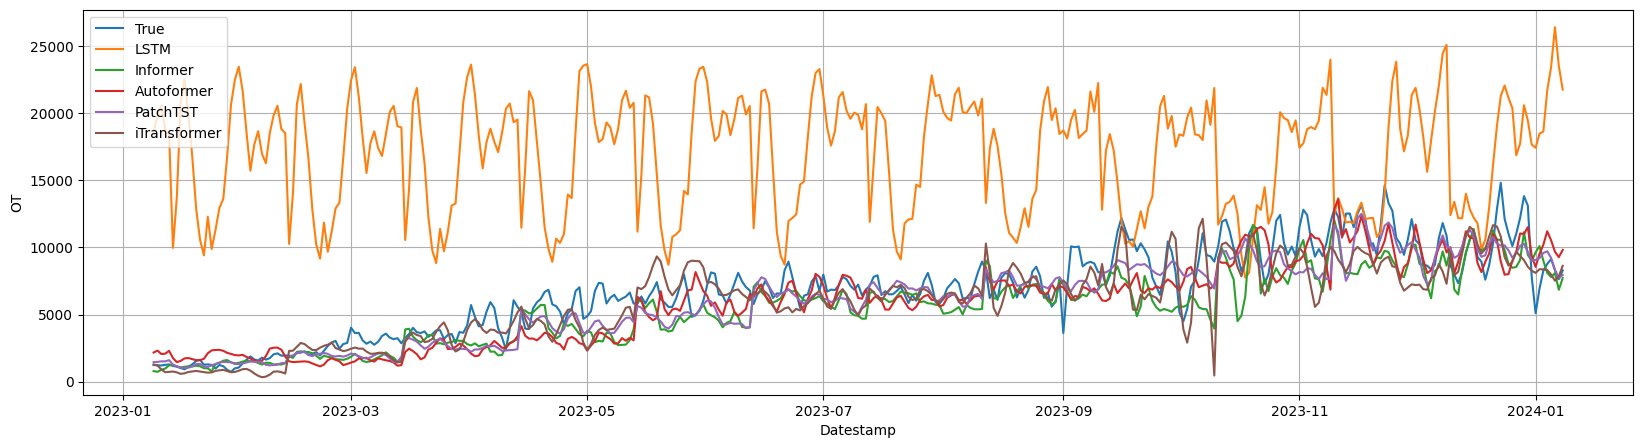

In [13]:
from matplotlib import pyplot as plt

Y_plot = cross_val[cross_val['unique_id'] == 'global_entry']
cutoffs = cross_val['cutoff'].unique()[::horizon]
Y_plot = Y_plot[cross_val['cutoff'].isin(cutoffs)]
Y_plot = Y_plot[-365:]

plt.figure(figsize=(20, 5))
plt.plot(Y_plot['ds'], Y_plot['y'], label='True')
plt.plot(Y_plot['ds'], Y_plot['AutoLSTM'], label='LSTM')
plt.plot(Y_plot['ds'], Y_plot['AutoInformer'], label='Informer')
plt.plot(Y_plot['ds'], Y_plot['AutoAutoformer'], label='Autoformer')
plt.plot(Y_plot['ds'], Y_plot['AutoPatchTST'], label='PatchTST')
plt.plot(Y_plot['ds'], Y_plot['AutoiTransformer'], label='iTransformer')
plt.xlabel('Datestamp')
plt.ylabel('OT')
plt.grid()
plt.legend()


In [9]:
from neuralforecast.losses.numpy import mae, rmse, mape


def eval_accuracy(model_name, y_true, y_pred):
    print(f'{model_name} -- mae: {mae(y_true, y_pred)},rmse: {rmse(y_true, y_pred)}, mape: {mape(y_true, y_pred)}')
    # return mae(y_true, y_pred), rmse(y_true, y_pred), mape(y_true, y_pred)


eval_accuracy('LSTM', cross_val['y'], cross_val['AutoLSTM'])
eval_accuracy('Informer', cross_val['y'], cross_val['AutoInformer'])
eval_accuracy('Autoformer', cross_val['y'], cross_val['AutoAutoformer'])
eval_accuracy('PatchTST', cross_val['y'], cross_val['AutoPatchTST'])
eval_accuracy('iTransformer', cross_val['y'], cross_val['AutoiTransformer'])

LSTM -- mae: 5707.382212727189,rmse: 8761.622897203484, mape: 10.834066089099252
Informer -- mae: 598.719161152749,rmse: 1109.2197749782988, mape: 1.0035921021521692
Autoformer -- mae: 671.0672397759339,rmse: 1483.7534266924574, mape: 1.752135864939253
PatchTST -- mae: 467.4948960914986,rmse: 832.5602973619566, mape: 0.8819475135720081
iTransformer -- mae: 624.8820707513971,rmse: 1245.956321709385, mape: 1.155896343395166


In [ ]:
reccurrent = 6

df_pred = nf.predict(df_long, step_size=1, random_seed=42)
df_pred['unique_id'] = df_pred.index

In [3]:
nf.save('./models', model_index=[0, 1, 2, 3, 4], overwrite=False, save_dataset=True)

NameError: name 'nf' is not defined